<a href="https://colab.research.google.com/github/Jvlia17/deep-learning/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(FeatureExtractor, self).__init__()
        # print(list(base_model.children())[0])
        # container = *list(base_model.children())[0]
        # container = container[:-1]
        # print(list(container.children())[0])
        # base_model.fc =nn.Identity()
        # self.features = base_model
        # print(list(base_model.children())[0])

        self.features = nn.Sequential(*list(base_model.children())[:-1])


    def forward(self, x):
        return self.features(x)


# my_model1 = nn.Sequential(*list(net.children())[:-1])
# print(net)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Trening PCA

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/DL/model/checkpoint_epoch_40.pth')


net = torchvision.models.resnet101(pretrained=False, num_classes=10)
net.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
net.maxpool = nn.Identity()

net.load_state_dict(checkpoint['model_state_dict'])

net.to('cpu')


model_ftex = torchvision.models.resnet101(pretrained=False, num_classes=10)
model_ftex.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_ftex.maxpool = nn.Identity()

model_ftex.load_state_dict(checkpoint['model_state_dict'])
model_ftex.fc = nn.Identity()
# print(list(net.children())[:])
model_ftex.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_ftex = FeatureExtractor(net)
model_ftex.to(device)
model_ftex.eval()

normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926])
batch_size = 128

train_loader = torch.utils.data.DataLoader(
            CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

counter = 0
features = []
labels = []
with torch.no_grad():
    for (inputs, targets) in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      for i in range(len(targets)):
        labels.append(targets[i].to('cpu'))
      outputs = model_ftex(inputs).to(device)
      for i in range(len(outputs)):
        output = torch.flatten(outputs[i])
        features.append(output.to('cpu'))
      print('Batch ', counter, '/', len(train_loader))
      counter = counter + 1

Files already downloaded and verified
Batch  0 / 391
Batch  1 / 391
Batch  2 / 391
Batch  3 / 391
Batch  4 / 391
Batch  5 / 391
Batch  6 / 391
Batch  7 / 391
Batch  8 / 391
Batch  9 / 391
Batch  10 / 391
Batch  11 / 391
Batch  12 / 391
Batch  13 / 391
Batch  14 / 391
Batch  15 / 391
Batch  16 / 391
Batch  17 / 391
Batch  18 / 391
Batch  19 / 391
Batch  20 / 391
Batch  21 / 391
Batch  22 / 391
Batch  23 / 391
Batch  24 / 391
Batch  25 / 391
Batch  26 / 391
Batch  27 / 391
Batch  28 / 391
Batch  29 / 391
Batch  30 / 391
Batch  31 / 391
Batch  32 / 391
Batch  33 / 391
Batch  34 / 391
Batch  35 / 391
Batch  36 / 391
Batch  37 / 391
Batch  38 / 391
Batch  39 / 391
Batch  40 / 391
Batch  41 / 391
Batch  42 / 391
Batch  43 / 391
Batch  44 / 391
Batch  45 / 391
Batch  46 / 391
Batch  47 / 391
Batch  48 / 391
Batch  49 / 391
Batch  50 / 391
Batch  51 / 391
Batch  52 / 391
Batch  53 / 391
Batch  54 / 391
Batch  55 / 391
Batch  56 / 391
Batch  57 / 391
Batch  58 / 391
Batch  59 / 391
Batch  60 / 

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
del train_loader
torch.cuda.empty_cache()

features_np = [x.numpy() for x in features]
features_np = np.array(features_np)
# flatten
print(features_np.shape)
# features_np = features_np.reshape(-1, features_np.shape[1] * features_np.shape[2] * features_np.shape[3])
features_np = features_np.reshape(-1, features_np.shape[1])
print(features_np.shape)
labels_np = np.array([y.squeeze().numpy() for y in labels])
print(labels_np)

features_col = ['Feature' + str(i) for i in range(features_np.shape[1])]
df_cifar = pd.DataFrame(features_np, columns = features_col)
df_cifar['Label'] = labels_np
print(df_cifar.head())


(50000, 2048)
(50000, 2048)
[3 1 5 ... 8 8 6]
   Feature0  Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
0       0.0  0.000000  0.016040  0.000000  0.018682  0.000000       0.0   
1       0.0  0.041125  0.279426  0.000000  0.000000  0.000000       0.0   
2       0.0  0.000000  0.000000  0.000000  0.000000  0.000000       0.0   
3       0.0  0.004911  0.004469  0.001088  0.086242  0.014583       0.0   
4       0.0  0.000000  0.000000  0.000000  0.000000  0.000000       0.0   

   Feature7  Feature8  Feature9  ...  Feature2039  Feature2040  Feature2041  \
0   0.00000  0.000000  0.000000  ...     0.000000     0.000000     0.000000   
1   0.00000  0.011258  0.000000  ...     0.000000     0.000341     0.000000   
2   0.00000  0.000000  0.008074  ...     0.000000     0.000000     0.000445   
3   0.00537  0.000000  0.023723  ...     0.003612     0.000000     0.000000   
4   0.00000  0.000000  0.000000  ...     0.000000     0.000000     0.000000   

   Feature2042  Feature2043 

Przeprowadzono zmniejszenie wymiarowości obrazów w celu porównania otrzymanych dwuwymiarowych wektrów reprezentujących różne klasy obrazów w przestrzeni cech.
Do zmniejszenia wymiarowości użyto metody PCA (*Principal Component Analysis*).

In [ ]:
pca_model = PCA(2)
# apply PCA to each column except the last one (label)
convereted_data = pca_model.fit_transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_np

print(df_converted_data.head())


   Principal Component 1  Principal Component 2  Label
0              -0.882226               0.056224      3
1               2.799738               0.703958      1
2              -1.322055               0.836858      5
3               0.339982               0.595689      0
4              -0.722652               1.366441      3


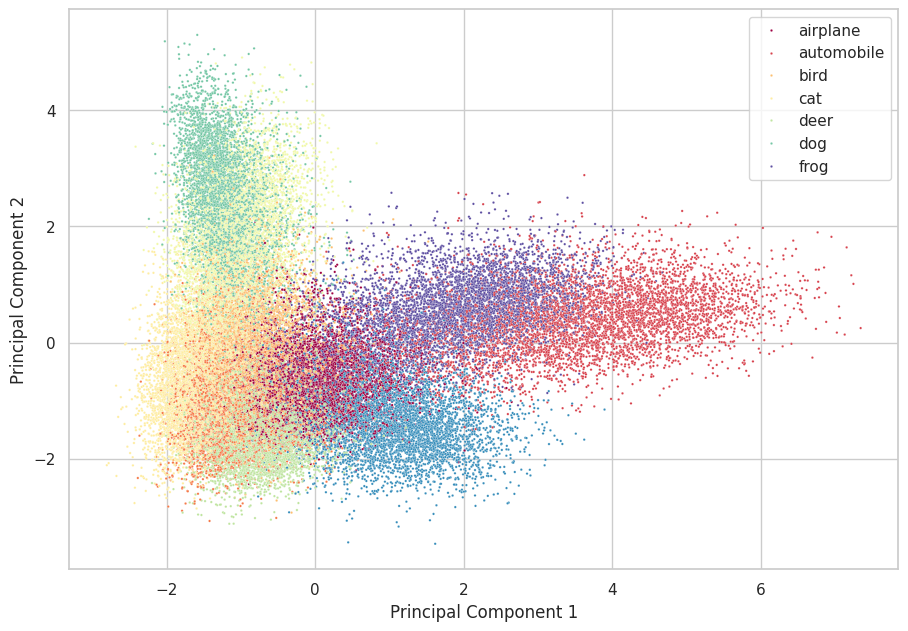

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 3)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.savefig("/content/PCA.pdf", format='pdf')

## Zastosowanie PCA

In [ ]:
test_loader = torch.utils.data.DataLoader(
            CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

counter = 0
features = []
labels = []
with torch.no_grad():
    for (inputs, targets) in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      for i in range(len(targets)):
        labels.append(targets[i].to('cpu'))
      outputs = model_ftex(inputs).to(device)
      for i in range(len(outputs)):
        output = torch.flatten(outputs[i], start_dim=1)
        features.append(output.to('cpu'))
      print('Batch ', counter, '/', len(test_loader))
      counter = counter + 1

Files already downloaded and verified
Batch  0 / 79
Batch  1 / 79
Batch  2 / 79
Batch  3 / 79
Batch  4 / 79
Batch  5 / 79
Batch  6 / 79
Batch  7 / 79
Batch  8 / 79
Batch  9 / 79
Batch  10 / 79
Batch  11 / 79
Batch  12 / 79
Batch  13 / 79
Batch  14 / 79
Batch  15 / 79
Batch  16 / 79
Batch  17 / 79
Batch  18 / 79
Batch  19 / 79
Batch  20 / 79
Batch  21 / 79
Batch  22 / 79
Batch  23 / 79
Batch  24 / 79
Batch  25 / 79
Batch  26 / 79
Batch  27 / 79
Batch  28 / 79
Batch  29 / 79
Batch  30 / 79
Batch  31 / 79
Batch  32 / 79
Batch  33 / 79
Batch  34 / 79
Batch  35 / 79
Batch  36 / 79
Batch  37 / 79
Batch  38 / 79
Batch  39 / 79
Batch  40 / 79
Batch  41 / 79
Batch  42 / 79
Batch  43 / 79
Batch  44 / 79
Batch  45 / 79
Batch  46 / 79
Batch  47 / 79
Batch  48 / 79
Batch  49 / 79
Batch  50 / 79
Batch  51 / 79
Batch  52 / 79
Batch  53 / 79
Batch  54 / 79
Batch  55 / 79
Batch  56 / 79
Batch  57 / 79
Batch  58 / 79
Batch  59 / 79
Batch  60 / 79
Batch  61 / 79
Batch  62 / 79
Batch  63 / 79
Batch  64 / 

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns


# features_np = [x.squeeze().numpy() for x in features]
# features_np = np.array(features_np)
# print(features_np.shape)
# labels_np = np.array([y.squeeze().numpy() for y in labels])
# print(labels_np)


# features = ['Feature' + str(i) for i in range(features_np.shape[1])]
# df_cifar = pd.DataFrame(features_np, columns = features)
# df_cifar['Label'] = labels_np
# print(df_cifar.head())


import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

features_np = [x.numpy() for x in features]
features_np = np.array(features_np)
# flatten
print(features_np.shape)
# features_np = features_np.reshape(-1, features_np.shape[1] * features_np.shape[2] * features_np.shape[3])
features_np = features_np.reshape(-1, features_np.shape[1])
print(features_np.shape)
labels_np = np.array([y.squeeze().numpy() for y in labels])
print(labels_np)

features_col = ['Feature' + str(i) for i in range(features_np.shape[1])]
df_cifar = pd.DataFrame(features_np, columns = features_col)
df_cifar['Label'] = labels_np
# print(df_cifar.head())


(10000, 2048, 1)
(10000, 2048)
[7 9 9 ... 2 8 0]


In [ ]:
# apply PCA to each column except the last one (label)
convereted_data = pca_model.transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_np

print(df_converted_data.head())


   Principal Component 1  Principal Component 2  Label
0              -1.230689               2.394982      7
1               0.990799               0.526082      9
2               1.921300              -0.542314      9
3               4.691547               0.840086      1
4              -0.596828              -0.095632      3


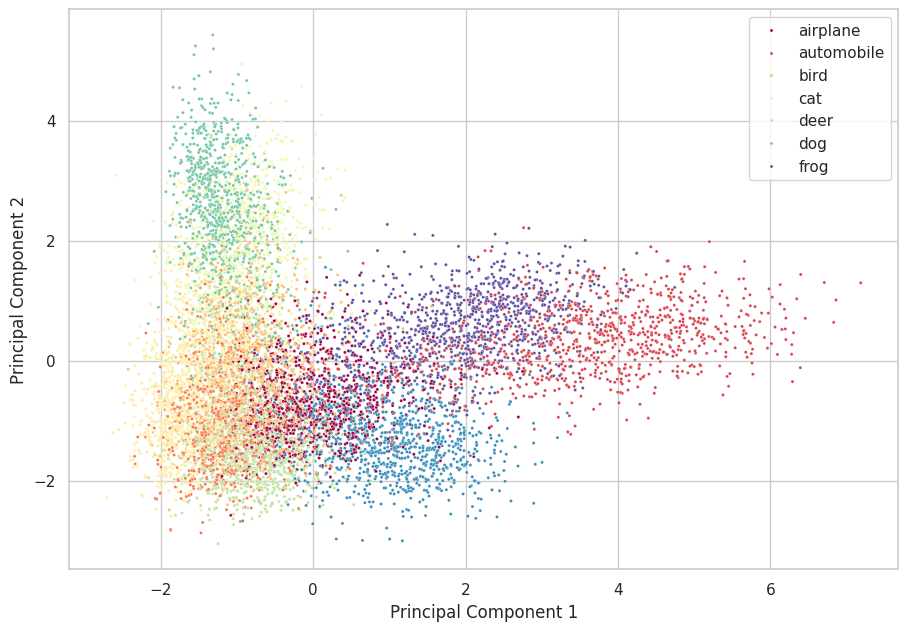

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 5)

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.savefig("/content/PCA.pdf", format='pdf')

## Porównanie próbki oryginalnej i adwersarzowej

In [ ]:
!pip install torchattacks

In [ ]:
import torchattacks
import torch
torch.cuda.empty_cache()
test_loader = torch.utils.data.DataLoader(
            CIFAR10(root='./data', train=False, transform=transforms.Compose([
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=8, shuffle=False, pin_memory=True)

attack = torchattacks.FGSM(net, eps=100/255)
# attack = torchattacks.attacks.pifgsm.PIFGSM(net)
model_ftex.eval()
model_ftex.to(device)
net.eval()
net.to(device)
counter = 0
features = []
labels = []

total = 0
correct = 0
correct_adv = 0


# predition on original and adversary examples
predict = []
predict_adv = []

# feauture extraction of original examples
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      if batch_idx == 30:
        break
      inputs, targets = inputs.to(device), targets.to(device)
      for i in range(len(targets)):
        labels.append(targets[i].to('cpu'))
      outputs = model_ftex(inputs).to(device)
      outputs_net = net(inputs).to(device)
      _, predicted = outputs_net.max(1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()
      for i in range(len(outputs)):
        features.append(outputs[i].to('cpu'))
      for i in range(len(predicted)):
        predict.append(predicted[i].to('cpu'))
      print('Batch ', counter, '/', len(test_loader))
      counter = counter + 1
torch.cuda.empty_cache()
counter = 0
# feauture extraction of  adversary examples
for batch_idx, (inputs, targets) in enumerate(test_loader):
  if batch_idx == 30:
    break
  inputs, targets = inputs.to(device), targets.to(device)
  # for i in range(len(targets)):
  #   labels.append(targets[i].to('cpu'))
  img_adv = attack(inputs, targets).to(device)
  outputs = model_ftex(img_adv).to(device)
  outputs_net = net(img_adv).to(device)
  _, predicted = outputs_net.max(1)
  correct_adv += (predicted == targets).sum().item()
  for i in range(len(outputs)):
    features.append(outputs[i].to('cpu'))
  for i in range(len(predicted)):
    predict.append(predicted[i].to('cpu'))
  print('Batch ', counter, '/', len(test_loader))
  counter = counter + 1

Files already downloaded and verified
Batch  0 / 1250
Batch  1 / 1250
Batch  2 / 1250
Batch  3 / 1250
Batch  4 / 1250
Batch  5 / 1250
Batch  6 / 1250
Batch  7 / 1250
Batch  8 / 1250
Batch  9 / 1250
Batch  10 / 1250
Batch  11 / 1250
Batch  12 / 1250
Batch  13 / 1250
Batch  14 / 1250
Batch  15 / 1250
Batch  16 / 1250
Batch  17 / 1250
Batch  18 / 1250
Batch  19 / 1250
Batch  20 / 1250
Batch  21 / 1250
Batch  22 / 1250
Batch  23 / 1250
Batch  24 / 1250
Batch  25 / 1250
Batch  26 / 1250
Batch  27 / 1250
Batch  28 / 1250
Batch  29 / 1250
Batch  0 / 1250
Batch  1 / 1250
Batch  2 / 1250
Batch  3 / 1250
Batch  4 / 1250
Batch  5 / 1250
Batch  6 / 1250
Batch  7 / 1250
Batch  8 / 1250
Batch  9 / 1250
Batch  10 / 1250
Batch  11 / 1250
Batch  12 / 1250
Batch  13 / 1250
Batch  14 / 1250
Batch  15 / 1250
Batch  16 / 1250
Batch  17 / 1250
Batch  18 / 1250
Batch  19 / 1250
Batch  20 / 1250
Batch  21 / 1250
Batch  22 / 1250
Batch  23 / 1250
Batch  24 / 1250
Batch  25 / 1250
Batch  26 / 1250
Batch  27 / 1

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

features_np = [x.detach().numpy() for x in features]
features_np = np.array(features_np)
# flatten
print(features_np.shape)
# features_np = features_np.reshape(-1, features_np.shape[1] * features_np.shape[2] * features_np.shape[3])
features_np = features_np.reshape(-1, features_np.shape[1])
# print(features_np.shape)
labels_db = labels + labels
predict_db = predict + predict_adv
labels_np = np.array([y.squeeze().numpy() for y in labels_db])
predict_np = np.array([y.squeeze().numpy() for y in predict_db])

features_col = ['Feature' + str(i) for i in range(features_np.shape[1])]

df_cifar = pd.DataFrame(features_np, columns = features_col)
df_cifar['Label'] = labels_np

# print(df_cifar.head())

# apply PCA to each column except the last one (label)
convereted_data = pca_model.transform(df_cifar.iloc[:,:-1])
df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
df_converted_data['Label'] = labels_np
df_converted_data['Predict'] = predict_np


print(df_converted_data.head())


(480, 2048)
   Principal Component 1  Principal Component 2  Label  Predict
0              -0.686024               0.581667      3        3
1               3.110291              -1.617145      8        8
2               1.978313              -0.626210      8        8
3               1.186927              -1.263996      0        8
4              -0.603133              -2.602551      6        6


In [ ]:
# accuracy

print("Acc: {}%".format(round(correct/total *100, 2)))
print("Acc adv: {}%".format(round(correct_adv/total*100, 2)))


240


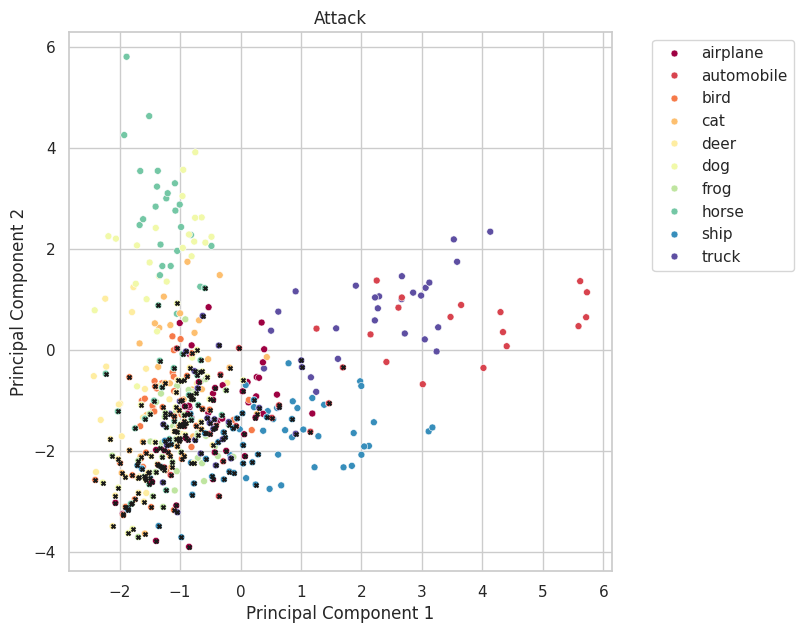

In [ ]:
split = features_np.shape[0] / 2
split = int(split)
print(split)

df_org = df_converted_data.iloc[:split,:]
df_adv = df_converted_data.iloc[split:,:]
df_adv = df_adv.reset_index()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(7,7)})
sns.set_style("whitegrid")
g = sns.scatterplot(data= df_converted_data, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                palette=sns.color_palette("Spectral", as_cmap=True),
                s = 25, legend='full')

plt.scatter(x=df_adv['Principal Component 1'] , y=df_adv['Principal Component 2'], color='k', marker="x", s=8)
plt.legend(bbox_to_anchor=(1, 1), title='Class')
# Write attack name
plt.title('Attack')
handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1.35, 1))
plt.savefig("/content/PCA.pdf", format='pdf', bbox_inches='tight')

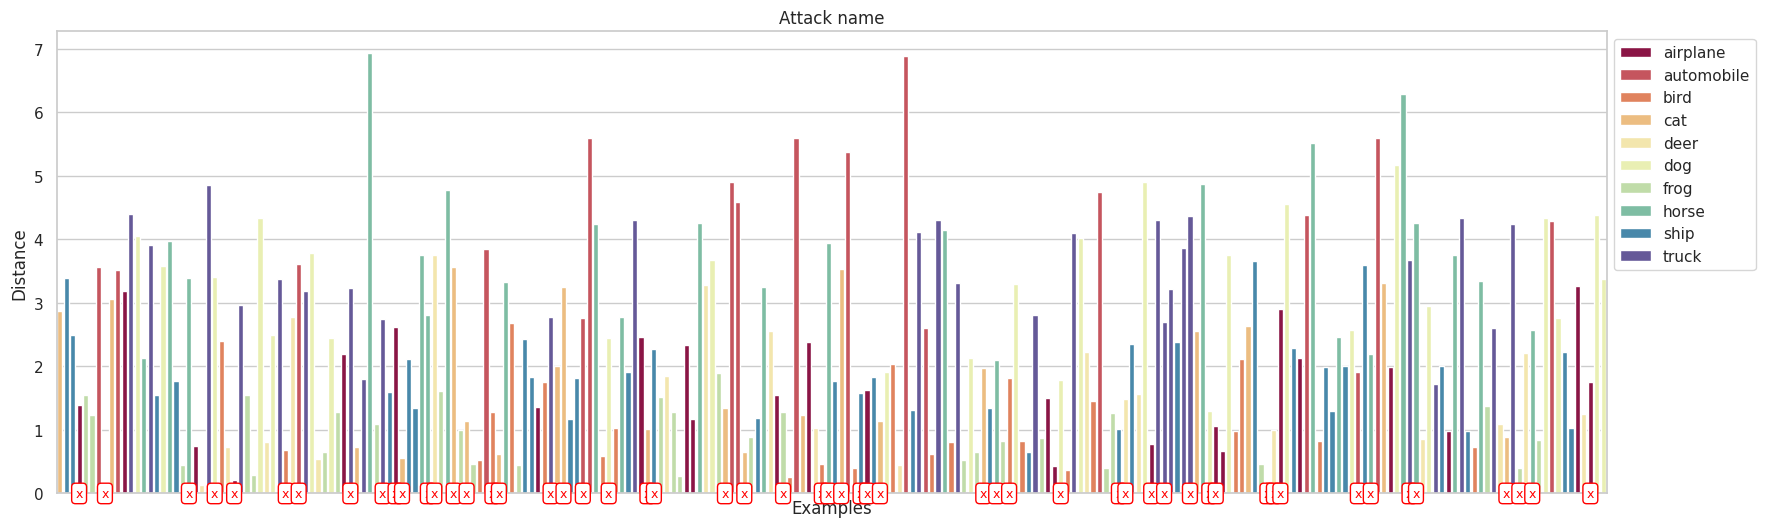

In [ ]:
# odległość euklidesowa
dist = np.sqrt((df_org['Principal Component 1'] - df_adv['Principal Component 1'])**2
              + (df_org['Principal Component 2'] - df_adv['Principal Component 2'])**2)
dist = pd.concat([dist, df_org['Label']], axis=1)
plt.figure(figsize=(20, 6))

sns.set_style("whitegrid")
g = sns.barplot(x=dist.index, y=dist[0], hue=dist['Label'],
                palette=sns.color_palette("Spectral", as_cmap=True),
                 legend='full')

handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, classes, bbox_to_anchor=(1, 1))
plt.xlabel('Examples')
plt.ylabel('Distance')
plt.title('Attack name')

plt.xticks([])

# annotate wrong predcitions
for i, (label, predict) in enumerate(zip(df_org['Label'], df_adv['Predict'])):
    if label != predict:
        plt.annotate('x',
                    xy=(i,0),
                    ha='center',
                    va='center',
                    color='red',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white'))
plt.savefig("/content/dist.pdf", format='pdf', bbox_inches='tight')

Files already downloaded and verified


tensor([8, 6], device='cuda:0')


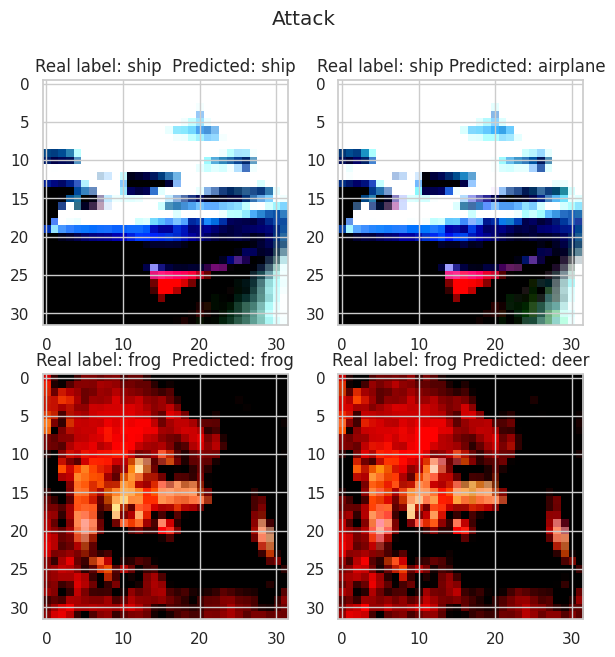

In [ ]:
'''
 Display example images and adversary images
'''


import torchattacks
from robustbench.data import load_cifar10
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
index = [1,5]
images = torch.tensor([]).to('cuda')
labels = []
for i in range(len(index)):
  img, label = testset[index[i]]
  img = img.unsqueeze(0).to('cuda')
  images = torch.cat((images, img), dim=0)
  labels.append(label)

labels = torch.tensor(labels)

preprocess = transforms.Compose([normalize])
images = preprocess(images)

# attack = torchattacks.FGSM(net, eps=80/255)
attack = torchattacks.attacks.pifgsm.PIFGSM(net)
img_adv = attack(images, labels).to('cuda')

# Predict unchanged and adversary examples
images.to('cuda')
images.to('cuda')
img_adv = img_adv.to('cuda')
net.to('cuda')

outputs = net(images).to(device)
_, predicted = outputs.max(1)
print(predicted)
outputs = net(img_adv)
_, predicted_adv = outputs.max(1)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

labelsnp = labels.numpy()
i = 0
counter = 1

plt.subplots_adjust(hspace=0.2)
# plt.rcParams['figure.figsize'] = [20, 40]
# Write attack name
plt.suptitle('Attack')
predicted = predicted.to('cpu').numpy()
predicted_adv = predicted_adv.to('cpu').numpy()
images = images.to('cpu')

img_adv = img_adv.to('cpu')
while i < len(index):
  plt.subplot(len(index), 2, counter)
  plt.title(f'Real label: {classes[labelsnp[i]]}  Predicted: {classes[predicted[i]]}')

  plt.imshow(images[i].permute(1, 2, 0))
  plt.subplot(len(index), 2,counter + 1)
  plt.title(f'Real label: {classes[labelsnp[i]]} Predicted: {classes[predicted_adv[i]]}')
  plt.imshow(img_adv[i].permute(1, 2, 0))
  counter = counter + 2
  i = i + 1

plt.savefig("/content/img-adv.pdf", format='pdf')

# Rodzaje ataków

## FGSM [[1]](https://arxiv.org/abs/1412.6572)

FGSM (*Fast Gradient Signed Method*) to pierwsza historycznie metoda atakowania ("oszukiwania") sieci neuronowych. Wprowadzając ją, pokazano, że wystarczy liniowa zmiana w przestrzeni wielowymiarowej, aby spreparować przykład adwersarzowy z powodzeniem. Trenowanie sieci z próbkami, które zmieniono tą metodą, stanowi również regurlazycję sieci i poprawia wyniki.

Atak jest atakiem *white box*, czyli atakując model, wiemy jaką ma architekturę, jakiego wejścia oczekuje, wagi i parametry modelu.

FGSM polega na dodaniu szumu do próbki w następujący sposób:

$$ η = x + ϵ \ \mathrm{sgn}{∇_x J(θ, x, y)}$$
gdzie $η$ to generowana próbka adwersarzowa, $x$ to obraz oryginalny, $y$ to
oryginalna etykieta próbki, $ϵ$ to współczynnik, który rrguluje wielkość dodawanych do obrazu zakłóceń, $Θ$ to parametry modelu, a $J$ to funkcja straty użyta podczas trenowania modelu.

Bierzemy gradient z próbki niezmienionej, ponieważ celem jest wygenerowanie obrazu, który będzie maksymalizował funkcję straty. Mierzone jest jak każdy piksel wpływa na wartość funkcji straty i odpowiednio dodawany jest szum.




Generacja próbki adwersarzowej:


In [ ]:
attack = torchattacks.FGSM(model, eps=50/255)
img_adv = attack(images, labels)



## PI-FGSM [[2]](https://arxiv.org/abs/2007.06765)


PI-FGSM (*Patch-wise Iterative Attack*) to atak typu *black-box*, czyli znany jest tylko rodzaj wejścia, jakie przyjmuje model. Wyróżniającą cechą tego ataku jest to, że nie wprowadza on szumu analizując piksele, a skupia się na obszarach. Motywowane jest to tym, że modele sieci neuronowych głębokich z reguły skupiają się na klastrach tworzonych przez piskele aniżeli tych rozsianych.

Jest to metoda itercyjna, co umożliwia na genrację silniejszych i bardziej efektywnych przykładów adwersarzowych
Pierwszym krokiem jest generacja szumu metodą FGSM.
Algorytm wykorzystuje przy tym heurystykę w rzutowaniu kierunku gradientu kiedy punkt w danej iteracji jest na krańcu regionu, by punkt pozostał w danym regionie w kolejnej iteracji. Wykonywane jest to poprzez rzutowanie dodatkowego szumu na otaczające pole (linie 6-10).

Algorytm:


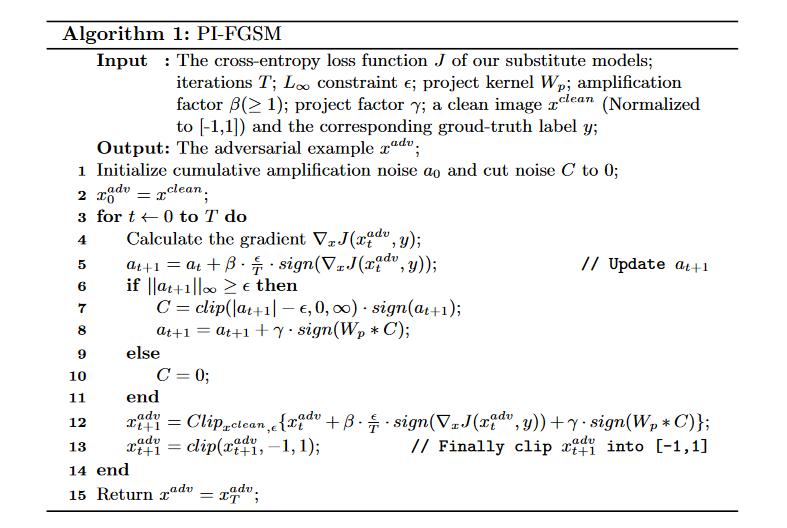

In [ ]:
attack = torchattacks.attacks.pifgsm.PIFGSM(model, max_epsilon=0.06274509803921569, num_iter_set=10, momentum=1.0, amplification=10.0, prob=0.7)
img_adv = attack(images, labels)

## One-pixel attack [[3]](https://arxiv.org/abs/1710.08864)



In [ ]:
import torchattacks
from robustbench.data import load_cifar10
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

def init_model():

  model_ftex = models.resnet152(pretrained=True)
  modules=list(model_ftex.children())[:-2]
  # print(list(model_ftex.children()))
  # print(modules)
  # print(len(modules))
  model_ftex=nn.Sequential(*modules).to(device)

  model_ftex.eval()


init_model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])

model = models.resnet152(pretrained=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

index = [0,1,3,5,6,11,12,13,22,25]
images = torch.tensor([])
labels = []
for i in range(len(index)):
  img, label = testset[index[i]]
  img = img.unsqueeze(0)
  images = torch.cat((images, img), dim=0)
  labels.append(label)

labels = torch.tensor(labels)


preprocess = transforms.Compose([
                # transforms.Resize((224,224)),
                transforms.RandomCrop(32, 4),
                normalize
            ])
images = preprocess(images)

attack = torchattacks.OnePixel(model, pixels=1, steps=10, popsize=10, inf_batch=128)

# model (nn.Module) – model to attack.
# pixels (int) – number of pixels to change (Default: 1)
# steps (int) – number of steps. (Default: 10)
# popsize (int) – population size, i.e. the number of candidate agents or “parents” in differential evolution (Default: 10)
# inf_batch (int) – maximum batch size during inference (Default: 128)

img_adv = attack(images, labels)

# Predict unchanged and adversary examples
outputs = model(images)
_, predicted = outputs.max(1)
outputs = model(img_adv)
_, predicted_adv = outputs.max(1)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

labels = labels.numpy()

i = 0
counter = 1

plt.subplots_adjust(hspace=0.5)
plt.rcParams['figure.figsize'] = [15, 15]
# Write attack name
plt.suptitle('One-pixel attack')

while i < len(index):
  plt.subplot(len(index), 2, counter)
  # plt.title(f'Real label: {classes[label[i]]} \n Predicted: {classes[predicted[i]]}')
  plt.title(f'Real label: {labels[i]} \n Predicted: {predicted[i]}')
  plt.imshow(images[i].permute(1, 2, 0))
  plt.subplot(len(index), 2,counter + 1)
  # plt.title(f'Real label: {classes[label[i]]} \n Predicted: {classes[predicted_adv[i]]}')
  plt.title(f'Real label: {labels[i]} \n Predicted: {predicted_adv[i]}')
  plt.imshow(img_adv[i].permute(1, 2, 0))
  counter = counter + 2
  i = i + 1

In [ ]:
def compare(img, img_a, label):
  '''
  Returns a pandas dataframe with image features
  '''

  img, img_a = img.unsqueeze(0).to(device), img_a.unsqueeze(0).to(device)

  with torch.no_grad():
   output = model_ftex(img).to('cpu')
   output_a =  model_ftex(img_a).to('cpu')

  # flatten
  output = torch.flatten(output, start_dim=1)
  output_a = torch.flatten(output_a, start_dim=1)

  features = [output, output_a]
  features_np = [x.squeeze().numpy() for x in features]
  features_np = np.array(features_np)

  labels = np.array([label, label])
  features = ['Feature' + str(i) for i in range(features_np.shape[1])]
  df_cifar = pd.DataFrame(features_np, columns = features)
  df_cifar['Label'] = labels
  df_cifar['Label'] = df_cifar['Label'].map(lambda label: classes[int(label)])
  # apply PCA to each column except the last one (label)
  convereted_data = pca_model.transform(df_cifar.iloc[:,:-1])
  df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
  df_converted_data['Label'] = df_cifar['Label']

  # print(df_converted_data.head())
  return df_converted_data


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))



df_feat = pd.DataFrame()

for i in range(len(index)):
  df = compare(images[i], img_adv[i], labels[i]).copy()
  df_feat = pd.concat([df_feat, df])


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(7,7)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_feat, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                # palette='rocket',
                s = 70, legend='full')

plt.scatter(x=df_feat['Principal Component 1'][1] , y=df_feat['Principal Component 2'][1], color='k', marker="x", s=100)
plt.legend(bbox_to_anchor=(1, 1), title='Class')
# Write attack name
plt.title('One-pixel attack')
plt.savefig("/content/PCA.pdf", format='pdf')

## PGD [[4]](https://arxiv.org/pdf/1706.06083.pdf)

In [ ]:
import torchattacks
from robustbench.data import load_cifar10
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

def init_model():

  model_ftex = models.resnet152(pretrained=True)
  modules=list(model_ftex.children())[:-2]
  # print(list(model_ftex.children()))
  # print(modules)
  # print(len(modules))
  model_ftex=nn.Sequential(*modules).to(device)

  model_ftex.eval()


init_model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])

model = models.resnet152(pretrained=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

index = [0,1,3,5,6,11,12,13,22,25]
images = torch.tensor([])
labels = []
for i in range(len(index)):
  img, label = testset[index[i]]
  img = img.unsqueeze(0)
  images = torch.cat((images, img), dim=0)
  labels.append(label)

labels = torch.tensor(labels)


preprocess = transforms.Compose([
                # transforms.Resize((224,224)),
                transforms.RandomCrop(32, 4),
                normalize
            ])
images = preprocess(images)

attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=10, random_start=True)

# model (nn.Module) – model to attack.
# eps (float) – maximum perturbation. (Default: 8/255)
# alpha (float) – step size. (Default: 2/255)
# steps (int) – number of steps. (Default: 10)
# random_start (bool) – using random initialization of delta. (Default: True)

img_adv = attack(images, labels)

# Predict unchanged and adversary examples
outputs = model(images)
_, predicted = outputs.max(1)
outputs = model(img_adv)
_, predicted_adv = outputs.max(1)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

labels = labels.numpy()

i = 0
counter = 1

plt.subplots_adjust(hspace=0.5)
plt.rcParams['figure.figsize'] = [15, 15]
# Write attack name
plt.suptitle('PGD Attack')

while i < len(index):
  plt.subplot(len(index), 2, counter)
  # plt.title(f'Real label: {classes[label[i]]} \n Predicted: {classes[predicted[i]]}')
  plt.title(f'Real label: {labels[i]} \n Predicted: {predicted[i]}')
  plt.imshow(images[i].permute(1, 2, 0))
  plt.subplot(len(index), 2,counter + 1)
  # plt.title(f'Real label: {classes[label[i]]} \n Predicted: {classes[predicted_adv[i]]}')
  plt.title(f'Real label: {labels[i]} \n Predicted: {predicted_adv[i]}')
  plt.imshow(img_adv[i].permute(1, 2, 0))
  counter = counter + 2
  i = i + 1

In [ ]:
def compare(img, img_a, label):
  '''
  Returns a pandas dataframe with image features
  '''

  img, img_a = img.unsqueeze(0).to(device), img_a.unsqueeze(0).to(device)

  with torch.no_grad():
   output = model_ftex(img).to('cpu')
   output_a =  model_ftex(img_a).to('cpu')

  # flatten
  output = torch.flatten(output, start_dim=1)
  output_a = torch.flatten(output_a, start_dim=1)

  features = [output, output_a]
  features_np = [x.squeeze().numpy() for x in features]
  features_np = np.array(features_np)

  labels = np.array([label, label])
  features = ['Feature' + str(i) for i in range(features_np.shape[1])]
  df_cifar = pd.DataFrame(features_np, columns = features)
  df_cifar['Label'] = labels
  df_cifar['Label'] = df_cifar['Label'].map(lambda label: classes[int(label)])
  # apply PCA to each column except the last one (label)
  convereted_data = pca_model.transform(df_cifar.iloc[:,:-1])
  df_converted_data = pd.DataFrame(data = convereted_data, columns = ['Principal Component 1', 'Principal Component 2'])
  df_converted_data['Label'] = df_cifar['Label']

  # print(df_converted_data.head())
  return df_converted_data


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))



df_feat = pd.DataFrame()

for i in range(len(index)):
  df = compare(images[i], img_adv[i], labels[i]).copy()
  df_feat = pd.concat([df_feat, df])


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.set(rc={'figure.figsize':(7,7)})
sns.set_style("whitegrid")
g = sns.scatterplot(data=df_feat, x="Principal Component 1",
                y="Principal Component 2", hue="Label",
                # palette='rocket',
                s = 70, legend='full')

plt.scatter(x=df_feat['Principal Component 1'][1] , y=df_feat['Principal Component 2'][1], color='k', marker="x", s=100)
plt.legend(bbox_to_anchor=(1, 1), title='Class')
# Write attack name
plt.title('PGD Attack')
plt.savefig("/content/PCA.pdf", format='pdf')